In [1]:
import numpy as np
from pandas import DataFrame as df

### Load the 3 dataset splits

In [2]:
from utils import load_dataset

val_set, _ = load_dataset('validation')
test_set, _ = load_dataset('test')
train_set, class_list = load_dataset('train')
datasets = {'validation':val_set, 'test':test_set,'train':train_set}

### Print class counts for each split

In [3]:
df({k:v['y'].value_counts() for k,v  in datasets.items()})

,validation,test,train
None of the above,168,280,672
Collaborative or Interactive AI,85,142,341
Acting or Performing machine,50,83,199
Complex AI,35,59,140
Thinking machine,25,42,100
Mysterious AI,8,13,32
Learning or recognition machine,2,3,9
Superior human,2,3,6


Some of these counts are horrible. The number of examples in 'Learning or recognition machine', 'Superior human' and 'Mysterious AI' are really too small. Also, the 'None of the above' class is very large, although that's not really a problem.

### Create a prompt for each class

In [4]:
acting = "Machine,robot or product, performing an act or task"
collab = "AI interacting with humans, AI performs a task that supports humans."
complx = "AI visualized as complex data, complex interactions/nodes/networks"
learning = "AI scanning or recognizing data points in traffic, shops, or faces"
mysterious = "AI working “magically” or in a mysterious way."
other = "car horse cat house bicycle cook shoe plane spider animal weapon boat tree"
superior = "AI depicted as technology that is created and/or controlled by humans."
thinking = "AI visualized as a brain, face, eye, android storing large amounts of data"

prompts = [acting, collab, complx, learning, mysterious, other, superior, thinking]
classes_by_prompt = {k:v for k, v in zip(prompts, class_list)}
classes_by_prompt

{'Machine,robot or product, performing an act or task': 'Acting or Performing machine',
 'AI interacting with humans, AI performs a task that supports humans.': 'Collaborative or Interactive AI',
 'AI visualized as complex data, complex interactions/nodes/networks': 'Complex AI',
 'AI scanning or recognizing data points in traffic, shops, or faces': 'Learning or recognition machine',
 'AI working “magically” or in a mysterious way.': 'Mysterious AI',
 'car horse cat house bicycle cook shoe plane spider animal weapon boat tree': 'None of the above',
 'AI depicted as technology that is created and/or controlled by humans.': 'Superior human',
 'AI visualized as a brain, face, eye, android storing large amounts of data': 'Thinking machine'}

### Create classifier using clip and the prompts

In [5]:
from PIL import Image
import clip
import torch
import numpy as np

def predict_image_with_clip(image_path):
    #See first example at https://github.com/openai/CLIP#usage
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    img = Image.open(image_path)
    image = preprocess(img).unsqueeze(0).to(device)
    text = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    prediction = np.argmax(probs)
    return prediction


    # for prob, label in sorted(zip(probs[0], labels), key=lambda x : x[0], reverse=True):
    #     print(f'{prob:.2f} {label}')

predict_image_with_clip(val_set['paths'][1])

3

In [6]:
from tqdm import tqdm

predicted = [class_list[predict_image_with_clip(p)] for p in tqdm(val_set['paths'][::])]
trues = val_set['y'][::].values

100%|██████████| 375/375 [24:48<00:00,  3.97s/it]


In [7]:
from pandas import DataFrame as df
print(df(predicted).value_counts())
print(df(trues).value_counts())

Acting or Performing machine       85
Collaborative or Interactive AI    79
Superior human                     77
Learning or recognition machine    60
Mysterious AI                      32
Thinking machine                   29
Complex AI                         13
dtype: int64
None of the above                  168
Collaborative or Interactive AI     85
Acting or Performing machine        50
Complex AI                          35
Thinking machine                    25
Mysterious AI                        8
Learning or recognition machine      2
Superior human                       2
dtype: int64


### Performance metrics for clip based classifier

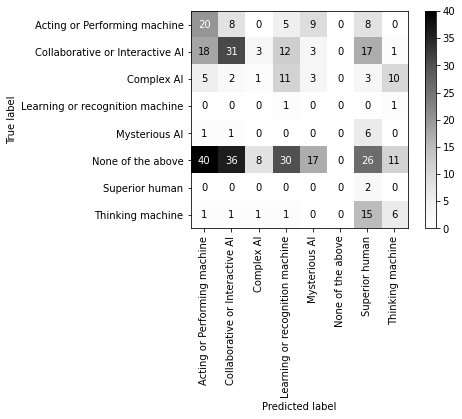

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(trues, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,                               display_labels=class_list)
_ = disp.plot(cmap='Greys', xticks_rotation='vertical')


In [9]:
from utils import print_performance_metrics

print_performance_metrics(trues, predicted, class_list)


accuracy_score 0.16266666666666665
recall_score [0.4        0.36470588 0.02857143 0.5        0.         0.
 1.         0.24      ]
precision_score [0.23529412 0.39240506 0.07692308 0.01666667 0.         0.
 0.02597403 0.20689655]
f1_score [0.2962963  0.37804878 0.04166667 0.03225806 0.         0.
 0.05063291 0.22222222]
krippendorff.alpha 0.18118860629224842


C:\Users\ChristiaanMeijer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
